In [1]:
from datasets import load_dataset
from huggingface_hub import login
import os
from dotenv import load_dotenv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print('tf.__version__:', tf.__version__)
print('GPUs:', len(tf.config.list_physical_devices('GPU')))
load_dotenv()

/home/alex/Desktop/SuperRes/sr_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-04 18:27:02.962878: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-04 18:27:03.526646: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 18:27:08.419103: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


tf.__version__: 2.20.0
GPUs: 0


2025-12-04 18:27:09.223093: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


True

In [2]:
login(token=os.getenv("HF_TOKEN"))
ds = load_dataset("shivamsark/div2k")
type(ds)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


datasets.dataset_dict.DatasetDict

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1280
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 320
    })
})

Dataset({
    features: ['image', 'label'],
    num_rows: 1280
})
image: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2040x1404 at 0x79AD8422C980>
label: 2
(1404, 2040, 3)
dummy


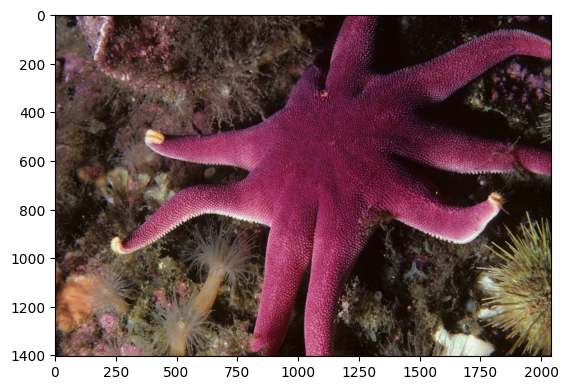

In [ ]:
# get and display first image in train dataset
print(ds['train'])
print("image:", ds['train'][0]['image'])
print("label:", ds['train'][0]['label'])

# first train image:
image = ds['train'][0]['image']
image_array = np.array(image)
print(image_array.shape)

imgplot = plt.imshow(image_array)

In [ ]:
# Because the dataset is not of a uniform size, training will be pain in the ass, 
# splitting into 32 x 32 blocks will take long. Not worth spending time on this. 
# pick a different dataset that's uniform. 

Fixed Datasets created:
train_dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None))>
val_dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None))>
test_dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None))>


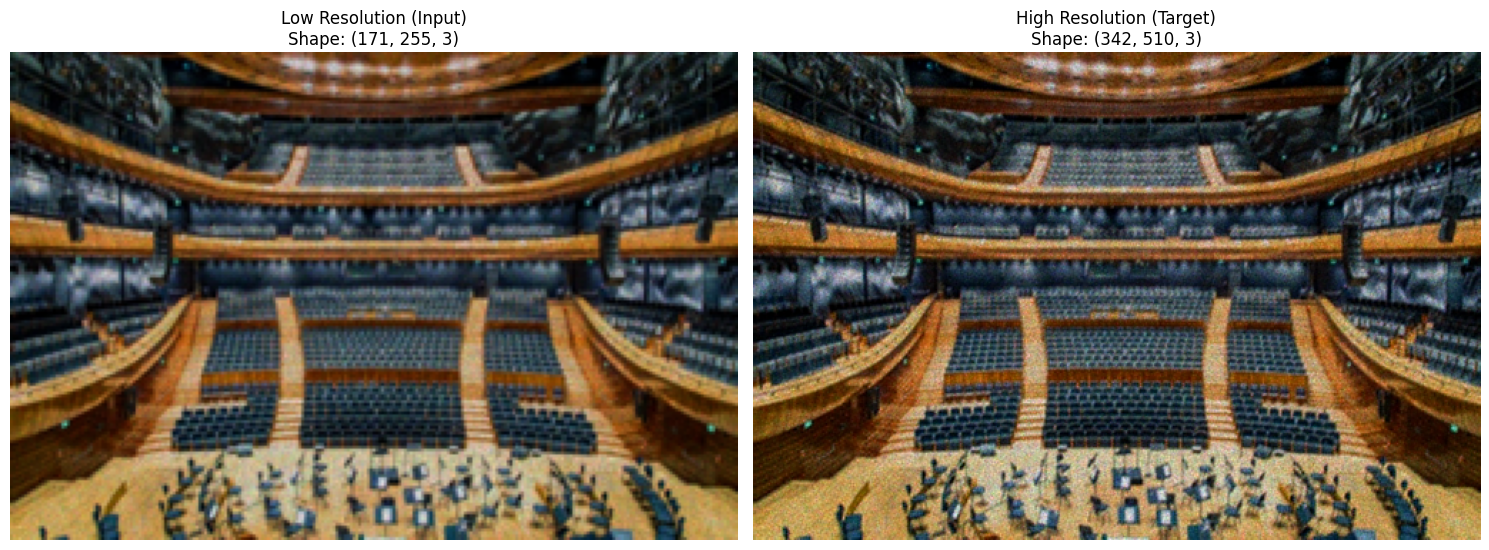

LR Image min/max: 0.00 / 0.93
HR Image min/max: 0.00 / 1.00


2025-12-04 18:27:35.956175: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Convert training images into 32 x 32 numpy blocks; 
# leave test images as is (inference should not break photo up into pieces);


In [10]:
print(type(train_dataset))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [6]:
# Create super-resolution model
def create_model():
    model = keras.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2DTranspose(
            filters=64,
            kernel_size=11,
            strides=4,
            padding='same',
            activation='sigmoid'
        ),
        layers.Conv2DTranspose(
            filters=32,
            kernel_size=9,
            strides=2,
            padding='same',
            activation='sigmoid'
        ),
        layers.Conv2DTranspose(
            filters = 16,
            kernel_size=9,
            strides=1,
            padding='same',
            activation='sigmoid'
        ),
        layers.Conv2DTranspose(
            filters = 16,
            kernel_size=9,
            strides=1,
            padding='same',
            activation='sigmoid'
        ),
        layers.Conv2DTranspose(
            filters = 3,
            kernel_size=5,
            strides=1,
            padding='same',
            activation='sigmoid'
        ),
        layers.AveragePooling2D(pool_size=(2,2)),
        layers.AveragePooling2D(pool_size=(2,2))
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = create_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_6              │ (None, 128, 128, 64)   │        23,296 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 256, 256, 32)   │       165,920 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 256, 256, 16)   │        41,488 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 256, 256, 16)   │        20,752 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 256, 256, 3)    │         1,203 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 128, 128, 3)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 64, 64, 3)      │             0 │
│ (AveragePooling2D)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,659 (986.95 KB)

 Trainable params: 252,659 (986.95 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Calculate the number of batches (steps)
# Since batch size is 1, steps = number of images
num_train_steps = len(train_val_split['train'])
num_val_steps = len(train_val_split['test'])

print(f"Training steps per epoch: {num_train_steps}")
print(f"Validation steps per epoch: {num_val_steps}")

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    steps_per_epoch=num_train_steps,  
    validation_steps=num_val_steps   
)

NameError: name 'train_val_split' is not defined

In [ ]:
# Calculate the number of test batches
# Since batch size is 1, steps = number of images
num_test_steps = len(ds['test'])

print(f"Test steps: {num_test_steps}")
print("Evaluating model on the test set...")
loss, mae = model.evaluate(
    test_dataset,
    steps=num_test_steps
)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

Test steps: 320
Evaluating model on the test set...
 70/320 ━━━━━━━━━━━━━━━━━━━━ 56s 227ms/step - loss: 0.0170 - mae: 0.1106

KeyboardInterrupt: 